In [1]:
from transformers import pipeline
from nltk.tokenize import sent_tokenize,word_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np

In [2]:
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HuyTinh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HuyTinh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Load Model

In [3]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else "cpu"

In [4]:
def load_model(device):
    theme_classifier = pipeline(
        task="zero-shot-classification",
        model=model_name,
        device=device  # Set to 0 for GPU, -1 for CPU
    )
    return theme_classifier

In [5]:
theme_classifier = load_model(device)

In [6]:
theme_list = ["firendship","battle", "seft development", "love", "sacrifice", "hope"]

In [7]:
theme_classifier(
    "I gave him a right hook then a left jab",
    theme_list,
    multi_label=True
)

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['battle',
  'firendship',
  'seft development',
  'hope',
  'sacrifice',
  'love'],
 'scores': [0.9121252298355103,
  0.6396022439002991,
  0.5008586645126343,
  0.08781788498163223,
  0.04500041902065277,
  0.004292412661015987]}

# Load Dataset

In [8]:
files = glob('../data/subtitles/*.ass')

In [9]:
files[:5]

['../data/subtitles\\01.ass',
 '../data/subtitles\\02.ass',
 '../data/subtitles\\03.ass',
 '../data/subtitles\\04.ass',
 '../data/subtitles\\05.ass']

In [10]:
with open(files[0], 'r') as file:
    lines = file.readlines()
    lines = lines[26:]
    lines = [",".join(line.split(",")[9:]) for line in lines]
    lines = [line.replace("\\N","") for line in lines]

In [11]:
lines[:2]

['Wealth, fame, power...\n', 'Gold Roger,the King of the Pirates,\n']

In [12]:
" ".join(lines[:10])

"Wealth, fame, power...\n Gold Roger,the King of the Pirates,\n attained everythingthis world has to offer.\n The words he uttered just beforehis death drove people to the seas.\n My treasure?If you want it, you can have it!\n Find it! I left everythingthis world has to offer there!\n And so men head for theGrand Line in pursuit of their dreams!\n The world has trulyentered a Great Pirate Era!\n We're going to gather upall our dreams\n and set out in searchof something to find\n"

In [13]:
int(files[0].split("\\")[-1].split(".")[0])

1

In [14]:
def load_subtitles_dataset(dataset_path):
    subtitles_path = glob(dataset_path + '/*.ass')
    
    scripts = []
    episode_nums = []
    
    for path in subtitles_path:
        
        #Read lines
        with open(files[0], 'r') as file:
            lines = file.readlines()
            lines = lines[26:]
            lines = [",".join(line.split(",")[9:]) for line in lines]
            
        lines = [line.replace("\\N","") for line in lines]
        script = " ".join(lines)
        
        episode = int(path.split("\\")[-1].split(".")[0])
        
        scripts.append(script)
        episode_nums.append(episode)
        
    
    df = pd.DataFrame.from_dict({"episode": episode_nums, "script": scripts})
    
    return df

In [15]:
dataset_path = "../data/subtitles"
df = load_subtitles_dataset(dataset_path)

In [16]:
df.head()

,episode,script
0,1,"Wealth, fame, power...\n Gold Roger,the King o..."
1,2,"Wealth, fame, power...\n Gold Roger,the King o..."
2,3,"Wealth, fame, power...\n Gold Roger,the King o..."
3,4,"Wealth, fame, power...\n Gold Roger,the King o..."
4,5,"Wealth, fame, power...\n Gold Roger,the King o..."


# Run Model

In [17]:
script = df.iloc[0]["script"]

In [18]:
script

'Wealth, fame, power...\n Gold Roger,the King of the Pirates,\n attained everythingthis world has to offer.\n The words he uttered just beforehis death drove people to the seas.\n My treasure?If you want it, you can have it!\n Find it! I left everythingthis world has to offer there!\n And so men head for theGrand Line in pursuit of their dreams!\n The world has trulyentered a Great Pirate Era!\n We\'re going to gather upall our dreams\n and set out in searchof something to find\n ONE PIECE!\n Compasses only cause delays\n Delirious with fever,I take the helm\n If the dusty treasure map hasbeen verified, it\'s not a legend!\n When it comes to personal storms,\n simply ride aboardsomeone else\'s biorhythm\n and pretend it isn\'t there!\n We\'re going to gather upall our dreams\n and set out in searchof something to find\n A coin in my pocket,and do you wanna be my friend?\n We are, We are on the cruise!\n We are!\n Whoa...\n "I\'m Luffy! The Man Who\'sGonna be King of the Pirates!"\n No 

In [19]:
script_sentences = sent_tokenize(script)
script_sentences[:2]

['Wealth, fame, power...\n Gold Roger,the King of the Pirates,\n attained everythingthis world has to offer.',
 'The words he uttered just beforehis death drove people to the seas.']

In [20]:
# Batch Sentence
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

In [21]:
script_batches[:2]

['Wealth, fame, power...\n Gold Roger,the King of the Pirates,\n attained everythingthis world has to offer. The words he uttered just beforehis death drove people to the seas. My treasure?If you want it, you can have it! Find it! I left everythingthis world has to offer there! And so men head for theGrand Line in pursuit of their dreams! The world has trulyentered a Great Pirate Era! We\'re going to gather upall our dreams\n and set out in searchof something to find\n ONE PIECE! Compasses only cause delays\n Delirious with fever,I take the helm\n If the dusty treasure map hasbeen verified, it\'s not a legend! When it comes to personal storms,\n simply ride aboardsomeone else\'s biorhythm\n and pretend it isn\'t there! We\'re going to gather upall our dreams\n and set out in searchof something to find\n A coin in my pocket,and do you wanna be my friend? We are, We are on the cruise! We are! Whoa...\n "I\'m Luffy! The Man Who\'sGonna be King of the Pirates!" No worries! A whirlpool of t

In [22]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [23]:
theme_output

[{'sequence': 'Wealth, fame, power...\n Gold Roger,the King of the Pirates,\n attained everythingthis world has to offer. The words he uttered just beforehis death drove people to the seas. My treasure?If you want it, you can have it! Find it! I left everythingthis world has to offer there! And so men head for theGrand Line in pursuit of their dreams! The world has trulyentered a Great Pirate Era! We\'re going to gather upall our dreams\n and set out in searchof something to find\n ONE PIECE! Compasses only cause delays\n Delirious with fever,I take the helm\n If the dusty treasure map hasbeen verified, it\'s not a legend! When it comes to personal storms,\n simply ride aboardsomeone else\'s biorhythm\n and pretend it isn\'t there! We\'re going to gather upall our dreams\n and set out in searchof something to find\n A coin in my pocket,and do you wanna be my friend? We are, We are on the cruise! We are! Whoa...\n "I\'m Luffy! The Man Who\'sGonna be King of the Pirates!" No worries! A w

In [24]:
# Wrangle output
themes = {}
for output in theme_output:
    for label, score in zip(output["labels"], output["scores"]):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)


In [25]:
themes = {key: np.mean(np.array(value)) for key, value in themes.items()}

In [26]:
themes

{'sacrifice': np.float64(0.7232642769813538),
 'hope': np.float64(0.43478353414684534),
 'firendship': np.float64(0.39890662021934986),
 'seft development': np.float64(0.5712641775608063),
 'battle': np.float64(0.6935632824897766),
 'love': np.float64(0.05244129180209711)}

In [27]:
def get_theme_inference(script):
    script_sentences = sent_tokenize(script)
    
    # Batch Sentence
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
        
    # Run Model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )
    
    # Wrangle output
    themes = {}
    for output in theme_output:
        for label, score in zip(output["labels"], output["scores"]):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key, value in themes.items()}
    
    return themes

In [28]:
df = df.head(2)

In [29]:
df

,episode,script
0,1,"Wealth, fame, power...\n Gold Roger,the King o..."
1,2,"Wealth, fame, power...\n Gold Roger,the King o..."


In [30]:
output_themes = df["script"].apply(get_theme_inference)

In [31]:
output_themes

0    {'sacrifice': 0.7232642769813538, 'hope': 0.43...
1    {'sacrifice': 0.7232642769813538, 'hope': 0.43...
Name: script, dtype: object

In [32]:
theme_df = pd.DataFrame(output_themes.to_list())

In [33]:
theme_df

,sacrifice,hope,firendship,seft development,battle,love
0,0.723264,0.434784,0.398907,0.571264,0.693563,0.052441
1,0.723264,0.434784,0.398907,0.571264,0.693563,0.052441


In [34]:
df

,episode,script
0,1,"Wealth, fame, power...\n Gold Roger,the King o..."
1,2,"Wealth, fame, power...\n Gold Roger,the King o..."


In [35]:
df[theme_df.columns] = theme_df
df

,episode,script,sacrifice,hope,firendship,seft development,battle,love
0,1,"Wealth, fame, power...\n Gold Roger,the King o...",0.723264,0.434784,0.398907,0.571264,0.693563,0.052441
1,2,"Wealth, fame, power...\n Gold Roger,the King o...",0.723264,0.434784,0.398907,0.571264,0.693563,0.052441


# Visualize output

In [49]:
# df = df.drop("sacrifice", axis=1)

In [50]:
theme_output = df.drop(['episode', 'script'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,hope,0.869567
1,firendship,0.797813
2,seft development,1.142528
3,battle,1.387127
4,love,0.104883


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

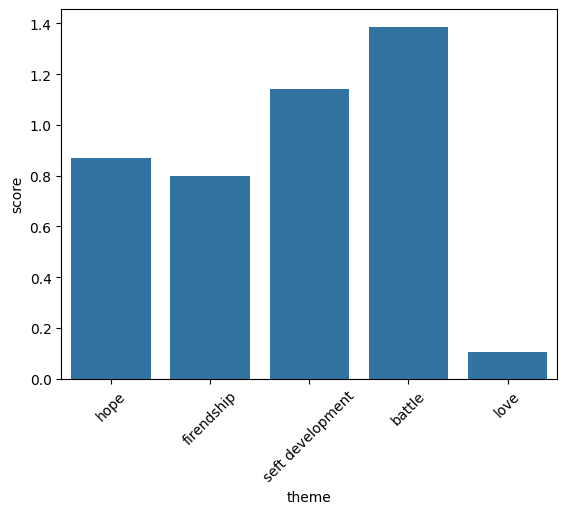

In [52]:
sns.barplot(data=theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()